# Checking for duplicate ROIs

In [2]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
import scipy

from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession

%load_ext autoreload
%autoreload 2

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_21213/2478721095.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [39]:
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = V1DDClient(base_folder)

In [92]:
all_metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)
all_metrics[all_metrics.is_valid & all_metrics.has_duplicate & ~all_metrics.is_ignored_duplicate]

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
M409828_11_4_94,409828,1,1,4,94,True,False,True,2,M409828_11_5_113,...,0.000829,0.000571,0.000665,0.266717,0.421115,0.008048,0.070959,"[0.104286976, 0.42111546, 0.2563252, -0.270476...",0.000493,0.003306
M409828_11_4_182,409828,1,1,4,182,True,False,True,2,M409828_11_5_48,...,0.000883,0.000475,0.000851,0.111348,0.200384,-0.148091,0.102242,"[0.4389483, -0.17863268, 0.20038436, 0.2387337...",0.000482,0.003488
M409828_11_5_6,409828,1,1,5,6,True,False,True,2,M409828_11_6_24,...,0.024517,0.000416,0.016067,-0.088815,-0.194943,-0.418368,-0.577932,"[0.03078708, -77.84999, -5.146723, -6.1924896,...",0.012368,0.036761
M409828_11_5_10,409828,1,1,5,10,True,False,True,2,M409828_11_6_8,...,0.004540,0.000606,0.001038,0.278216,0.435319,-0.066479,0.323943,"[-1.2395437, 0.08333116, -8.495023, 0.03968650...",0.002037,0.011197
M409828_12_1_34,409828,1,2,1,34,True,False,True,2,M409828_12_2_241,...,0.005652,0.000585,0.000730,0.720090,0.837270,-0.138012,0.202288,"[-0.4620939, -1.1606169, 0.9590448, -1.7576228...",0.001827,0.011400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_15_3_82,409828,1,5,3,82,True,False,True,3,"M409828_15_1_134, M409828_15_2_82",...,0.001104,0.001106,0.000160,0.760428,0.863912,0.052165,-0.043254,"[0.8639124, 0.44611713, 0, 0.4877202, -0.08218...",0.000385,0.003574
M409828_15_3_122,409828,1,5,3,122,True,False,True,3,"M409828_15_2_205, M409828_15_2_283",...,0.000839,0.001205,0.000118,0.861766,0.925751,0.177293,0.054767,"[0.35809708, 0, 0.925751, 0.3164405, -0.098051...",0.000430,0.003252
M409828_15_3_148,409828,1,5,3,148,True,False,True,3,"M409828_15_2_275, M409828_15_4_105",...,0.001160,0.000426,0.000810,0.334426,0.501228,0.047638,-0.323453,"[-1.0056368, -2.4666903, 0.47523385, 0.0541661...",0.000657,0.004275
M409828_15_4_68,409828,1,5,4,68,True,False,True,2,M409828_15_3_89,...,0.000611,0.000801,0.000689,0.355896,0.524960,0.218028,-0.347625,"[-0.68826073, 0.55566436, 0.55217624, 0.524960...",0.000365,0.002395


# Automated checking for duplicate ROIs

In [5]:
# Load metrics
metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)
metrics = metrics[metrics.is_valid]
def str_to_int(x):
    try:
        return int(x)
    except:
        return str(x)
metrics["volume"] = metrics.volume.apply(str_to_int)

# Tuning curve fits
from stimulus_analysis import fit_utils
metrics.insert(5, "roi_lookup", metrics.apply(lambda row: f"{row.column}-{row.volume}-{row.plane}-{row.roi}", axis=1))
metrics["ssi_fit"] = fit_utils.compute_dg_fit_ssi_from_metrics(metrics)
metrics["dgw_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgw")
metrics["dgf_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgf")
metrics["dgw_r2_fit"] = fit_utils.get_dg_r2_score(metrics, "dgw")
metrics["dgf_r2_fit"] = fit_utils.get_dg_r2_score(metrics, "dgf")

metrics.head()

,mouse,column,volume,plane,roi,roi_lookup,is_valid,depth,dgf_pref_response,dgf_pref_dir,...,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit,dgw_r2_fit,dgf_r2_fit
M409828_11_1_89,409828,1,1,1,89,1-1-1-89,True,50,0.000943,330.0,...,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903,0.173092,351.613700,63.683119,0.317339,0.191516
M409828_11_2_0,409828,1,1,2,0,1-1-2-0,True,66,0.000919,270.0,...,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629,-0.076999,46.319837,71.813432,0.030397,0.143525
M409828_11_2_1,409828,1,1,2,1,1-1-2-1,True,66,0.011217,0.0,...,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262,-0.357757,20.629574,14.344481,0.992914,0.996841
M409828_11_2_2,409828,1,1,2,2,1-1-2-2,True,66,0.001237,120.0,...,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412,0.238414,360.000000,63.556494,0.731243,0.072976
M409828_11_2_4,409828,1,1,2,4,1-1-2-4,True,66,0.001093,240.0,...,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601,-0.131294,349.940152,323.599541,0.611449,0.241362


In [6]:
# Hyperparameters
DG_RESPONSIVENESS_THRESHOLD = 0.5
ROI_MASK_SIMILARITY_THRESHOLD = 0.75
CENTROID_DISTANCE_THRESHOLD = 20
DG_FIT_R2_THRESH = 0.6
MOUSE = 409828
COLUMN = 1

In [7]:
metrics[(metrics.mouse == MOUSE) & (metrics.column == COLUMN)].volume.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 'a', 'b', 'c', 'd', 'e', 'f'],
      dtype=object)

In [8]:
# We are only going to use volumes 1-9
volumes = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
# Helper functions
def get_roi_centroid_distances(sess, plane1, plane2):
    roi_pos_1 = np.empty((len(sess.get_rois(plane1)), 2)) # 2 dims for x and y coords
    roi_pos_2 = np.empty((len(sess.get_rois(plane2)), 2))

    for (plane, pos_arr) in ((plane1, roi_pos_1), (plane2, roi_pos_2)):
        for roi in sess.get_rois(plane):
            if sess.is_roi_valid(plane, roi):
                mask = sess.get_roi_image_mask(plane, roi)
                pos_arr[roi, :] = np.mean(np.where(mask), axis=1) # each row is a pixel coordinate in the mask; taking mean of columns
            else:
                pos_arr[roi, :] = np.nan # Invalid roi
    
    centroid_distances = np.linalg.norm(roi_pos_1[:, np.newaxis, :] - roi_pos_2[np.newaxis, :, :], axis=2) # shape (n_rois_1, n_rois_2)
    return centroid_distances

def get_dg_pref_dir(row):
    if row.dgw_frac_responsive_trials >= DG_RESPONSIVENESS_THRESHOLD and row.dgw_r2_fit >= DG_FIT_R2_THRESH:
        return row.dgw_pref_dir_fit
        # return row.dgw_pref_dir
    elif row.dgf_frac_responsive_trials >= DG_RESPONSIVENESS_THRESHOLD and row.dgf_r2_fit >= DG_FIT_R2_THRESH:
        return row.dgf_pref_dir_fit
        # return row.dgf_pref_dir
    else:
        return None

In [24]:
duplicate_df = pd.DataFrame(columns=["mouse", "column", "volume", "plane_1", "roi_1", "plane_2", "roi_2", "roi_mask_similarity", "confidence"])

for volume in tqdm(volumes, desc="Computing duplicate ROIs"):
    metrics_mcv = (metrics.mouse == MOUSE) & (metrics.column == COLUMN) & (metrics.volume == volume)
    
    # Load ophys session (needed to get centroids)
    sess = client.load_ophys_session(mouse=MOUSE, column=COLUMN, volume=volume)
    planes = sess.get_planes()

    for plane_i in range(len(planes) - 1): # all but the last plane
        plane1, plane2 = planes[plane_i:plane_i+2]
        centroid_distances = get_roi_centroid_distances(sess, plane1, plane2)
        
        for roi1, roi2 in zip(*np.where(centroid_distances <= CENTROID_DISTANCE_THRESHOLD)):
            mask1 = sess.get_roi_image_mask(plane1, roi1)
            mask2 = sess.get_roi_image_mask(plane2, roi2)
            similarity = np.sum(mask1 & mask2) / np.sum(mask1 | mask2) # Jaccard similarity, intersection over union

            if similarity >= ROI_MASK_SIMILARITY_THRESHOLD:
                # Very similar ROI masks
                # Get metrics rows
                metrics1 = metrics[metrics_mcv & (metrics.plane == plane1) & (metrics.roi == roi1)].iloc[0]
                metrics2 = metrics[metrics_mcv & (metrics.plane == plane2) & (metrics.roi == roi2)].iloc[0]

                # Get pref dirs
                prefdir1 = get_dg_pref_dir(metrics1)
                prefdir2 = get_dg_pref_dir(metrics2)

                # Not DG responsive
                if prefdir1 == None or prefdir2 == None:
                    continue
                
                confidence = None
                diff = abs(prefdir1 - prefdir2)

                if diff <= 5:
                    confidence = "Almost surely"
                elif diff <= 15:
                    confidence = "Very likely"
                elif diff <= 30:
                    confidence = "Likely"
                else:
                    continue
                    
                # Add row to duplicate table
                duplicate_df.loc[len(duplicate_df)] = (MOUSE, COLUMN, volume, plane1, roi1, plane2, roi2, similarity, confidence)

print(f"There are {len(duplicate_df)} likely duplicates across {len(volumes)} volumes")
duplicate_df

Computing duplicate ROIs:   0%|          | 0/9 [00:00<?, ?it/s]

There are 127 likely duplicates across 9 volumes


,mouse,column,volume,plane_1,roi_1,plane_2,roi_2,roi_mask_similarity,confidence
0,409828,1,1,4,129,5,249,0.800000,Very likely
1,409828,1,2,2,69,3,88,0.774038,Almost surely
2,409828,1,2,2,76,3,105,0.830601,Very likely
3,409828,1,2,2,92,3,58,0.765306,Very likely
4,409828,1,2,2,115,3,145,0.805344,Almost surely
...,...,...,...,...,...,...,...,...,...
122,409828,1,4,5,169,6,103,0.769663,Very likely
123,409828,1,5,2,35,3,22,0.762821,Almost surely
124,409828,1,5,2,105,3,97,0.768953,Almost surely
125,409828,1,5,3,61,4,77,0.770574,Very likely


In [29]:
duplicate_df.volume.value_counts()

3    70
2    28
4    24
5     4
1     1
Name: volume, dtype: int64

In [27]:
duplicate_df.confidence.value_counts()

Almost surely    89
Very likely      33
Likely            5
Name: confidence, dtype: int64

In [25]:
duplicate_df.to_csv("/Users/chase/Desktop/duplicate_rois_M409828_C1.csv", index=None)

In [28]:
duplicates_v3 = duplicate_df[duplicate_df.volume == 3]
duplicates_v3.to_csv("/Users/chase/Desktop/duplicate_rois_M409828_C1_V3.csv", index=None)
print(len(duplicates_v3))
duplicates_v3.confidence.value_counts()

70


Almost surely    49
Very likely      18
Likely            3
Name: confidence, dtype: int64

# Miscellaneous testing

In [30]:
sess = client.load_ophys_session(mouse=MOUSE, column=1, volume=3)

array([[1.        , 0.01649497],
       [0.01649497, 1.        ]])

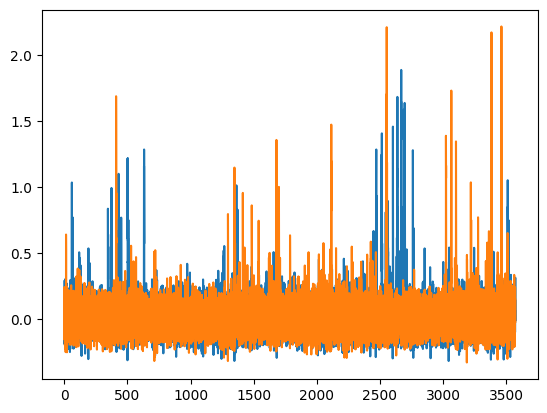

In [46]:
# Test correlation between traces
plane1, roi1, plane2, roi2 = 2, 69, 3, 88
traces1, timestamps1 = sess.get_traces(plane=plane1, roi=roi1, trace_type="dff")
traces2, timestamps2 = sess.get_traces(plane=plane2, roi=roi2, trace_type="dff")

plt.plot(timestamps1, traces1)
plt.plot(timestamps2, traces2)

# scipy.stats.linregress(traces1, traces2)
np.corrcoef(traces1, traces2)


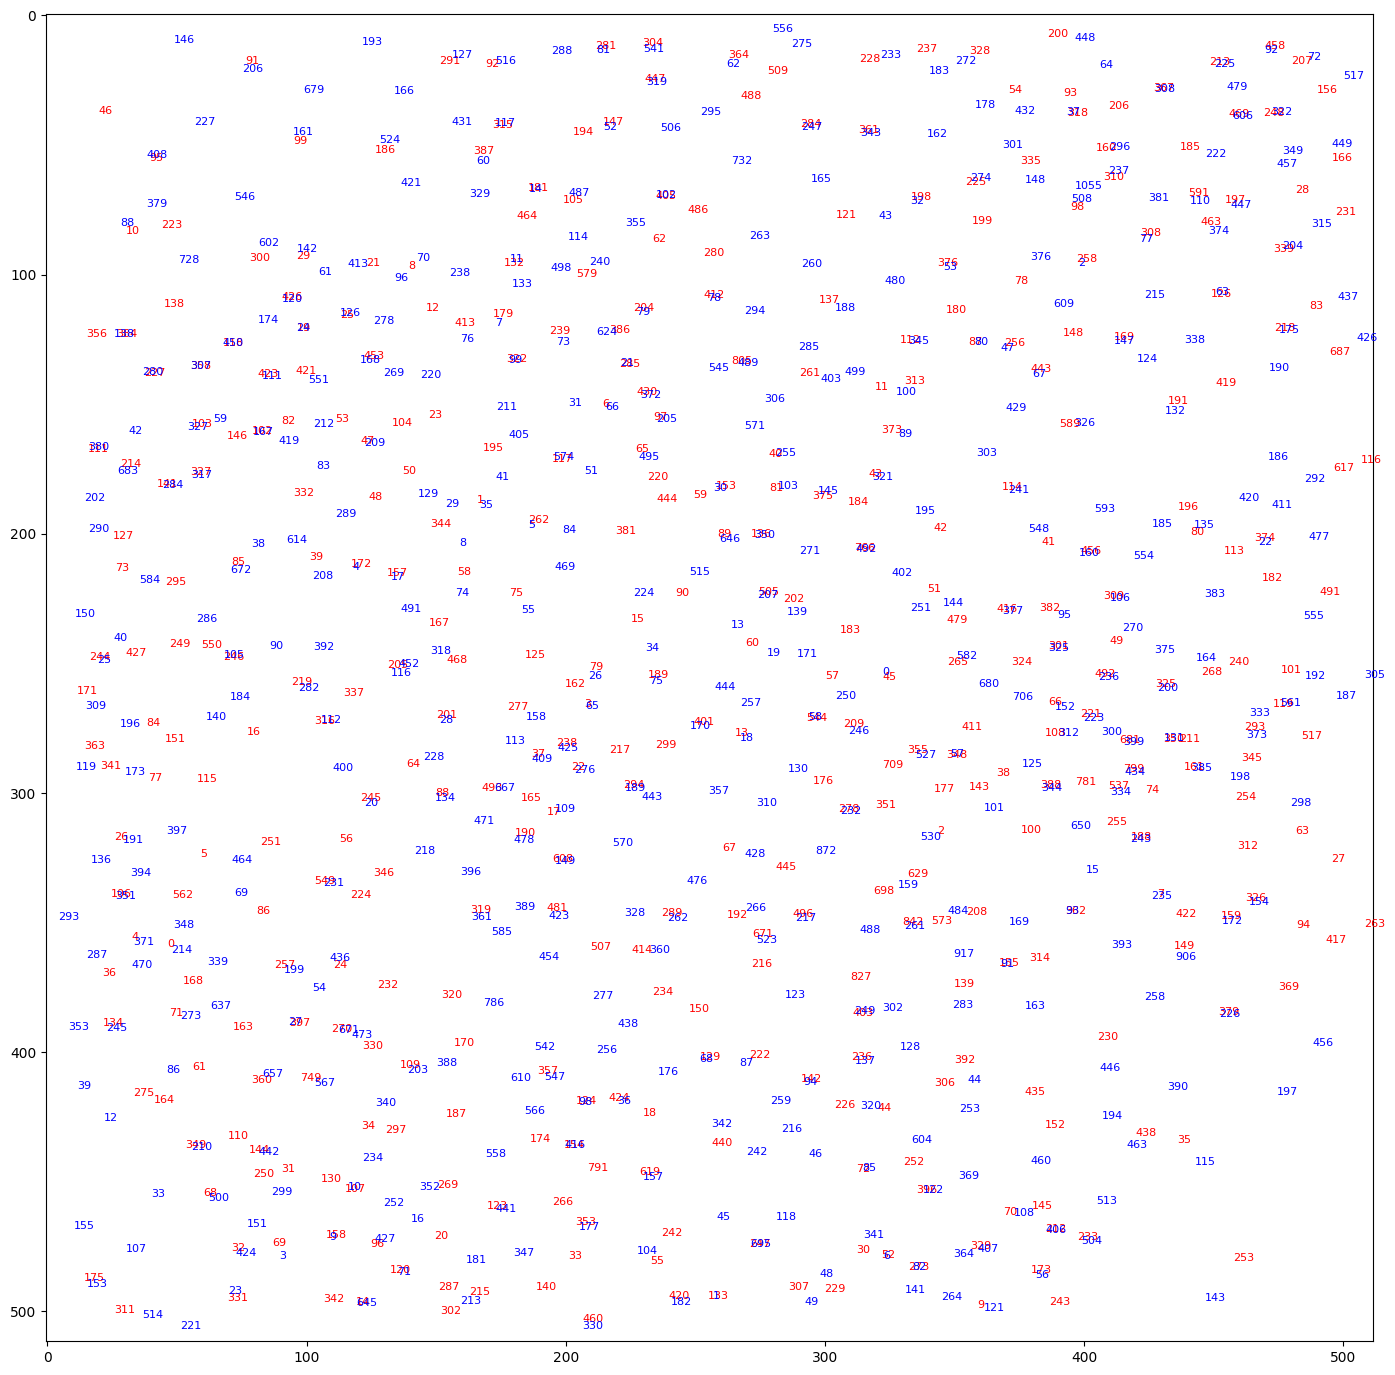

In [37]:
fig, ax = plt.subplots(figsize=(14, 14))

for plane, color in ((1, "red"), (2, "blue")):
# for plane, color in ((1, "red"), ):
    for roi in sess.get_rois(plane):
        if sess.is_roi_valid(plane, roi):
            mask = sess.get_roi_image_mask(plane, roi)
            centroid = np.mean(np.where(mask), axis=1)
            ax.text(*centroid, f"{roi}", fontsize=8, color=color)

ax.imshow(mask * 0, interpolation="nearest", cmap="gray_r")
fig.tight_layout()

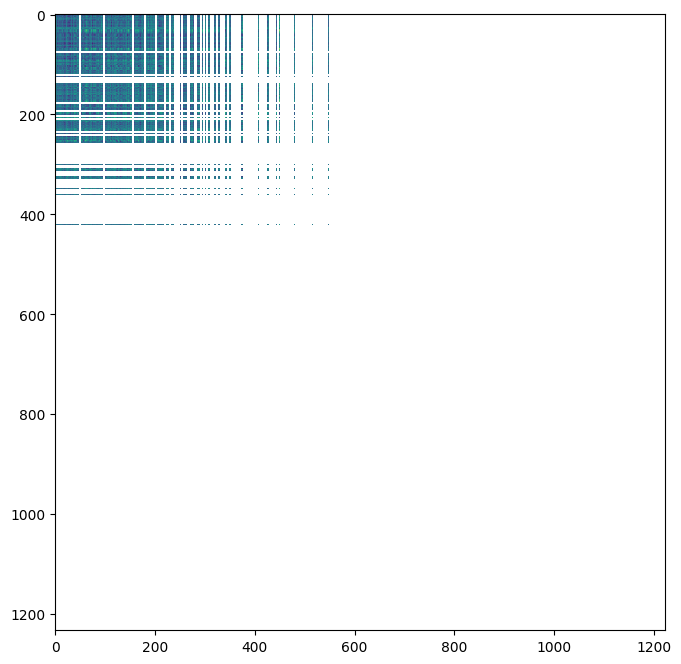

In [15]:
roi_pos_1 = np.empty((len(sess.get_rois(1)), 2))
roi_pos_2 = np.empty((len(sess.get_rois(2)), 2))

for (plane, pos_arr) in ((1, roi_pos_1), (2, roi_pos_2)):
    for roi in sess.get_rois(plane):
        if sess.is_roi_valid(plane, roi):
            mask = sess.get_roi_image_mask(plane, roi)
            pos_arr[roi, :] = np.mean(np.where(mask), axis=1)
        else:
            pos_arr[roi, :] = np.nan

centroid_distances = np.linalg.norm(roi_pos_1[:, np.newaxis, :] - roi_pos_2[np.newaxis, :, :], axis=2)

plt.figure(figsize=(8, 8))
plt.imshow(centroid_distances)

In [ ]:
from stimulus_analysis.drifting_gratings import DriftingGratings

dg1 = DriftingGratings(sess, 1, dg_type="full")
dg2 = DriftingGratings(sess, 2, dg_type="full")

# Load metrics
for dg in (dg1, dg2):
    # Make it load faster
    dg.n_chisq_shuffles = 10
    dg.n_null_distribution_boot = 100
    dg.metrics

447 319


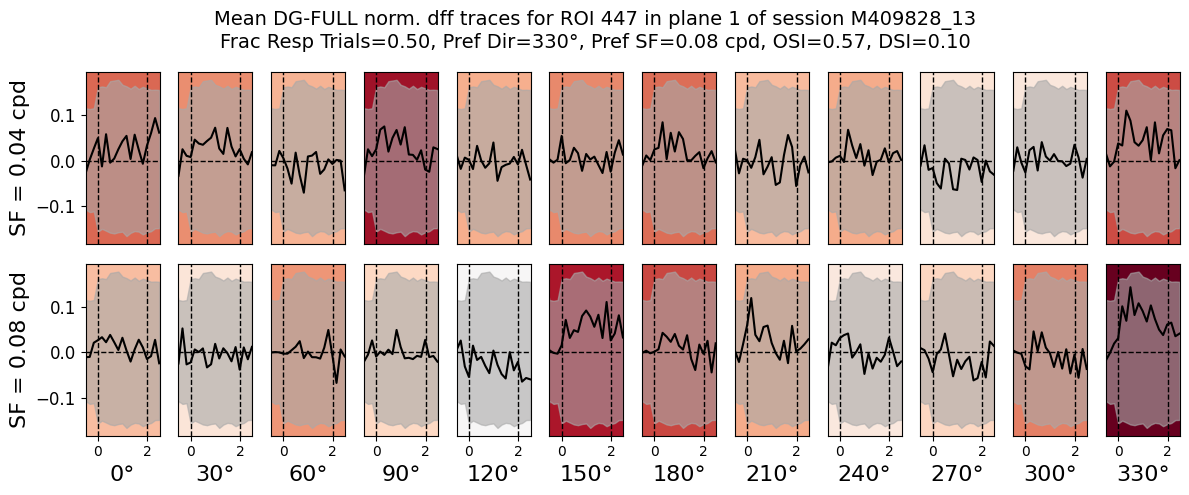

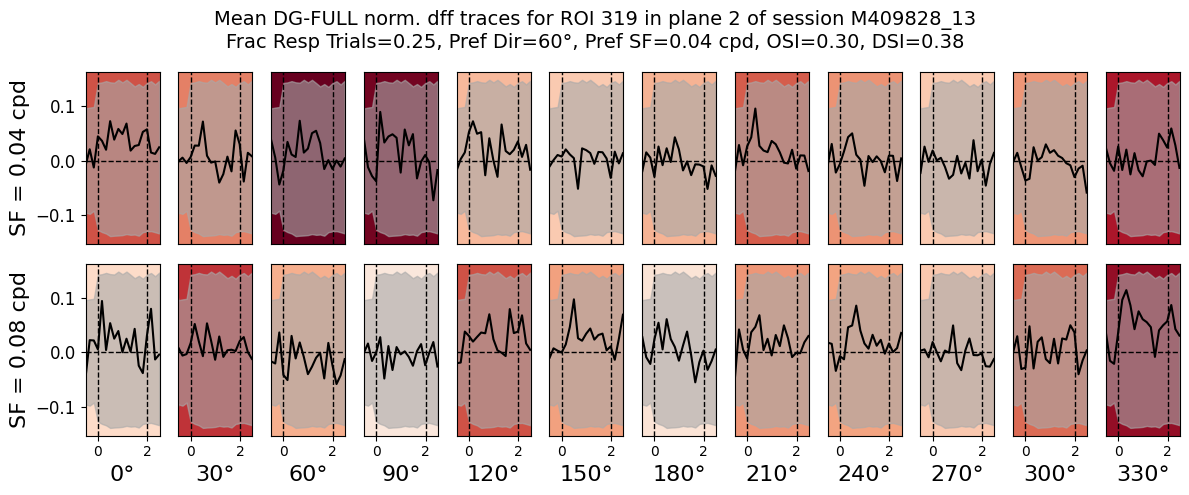

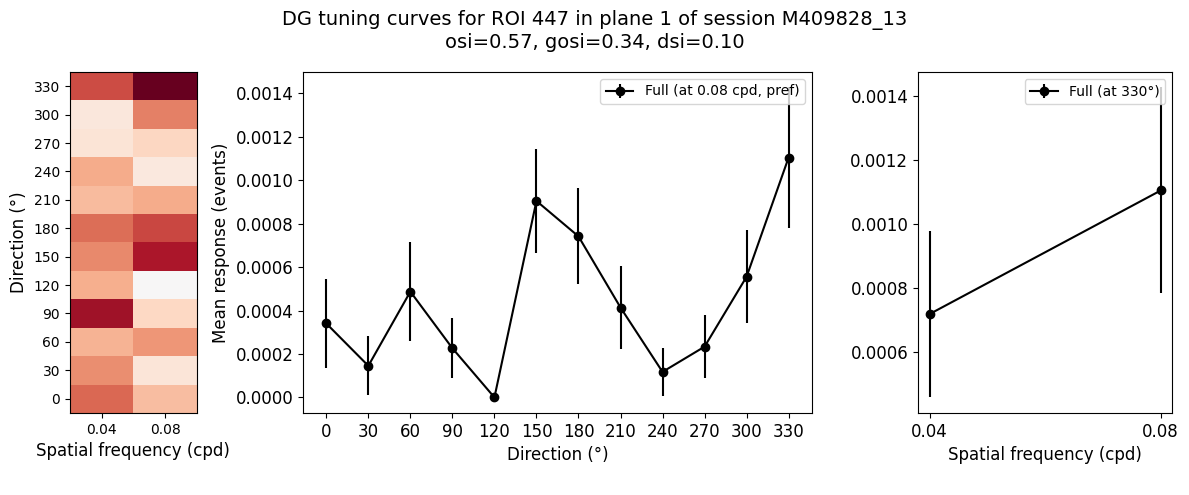

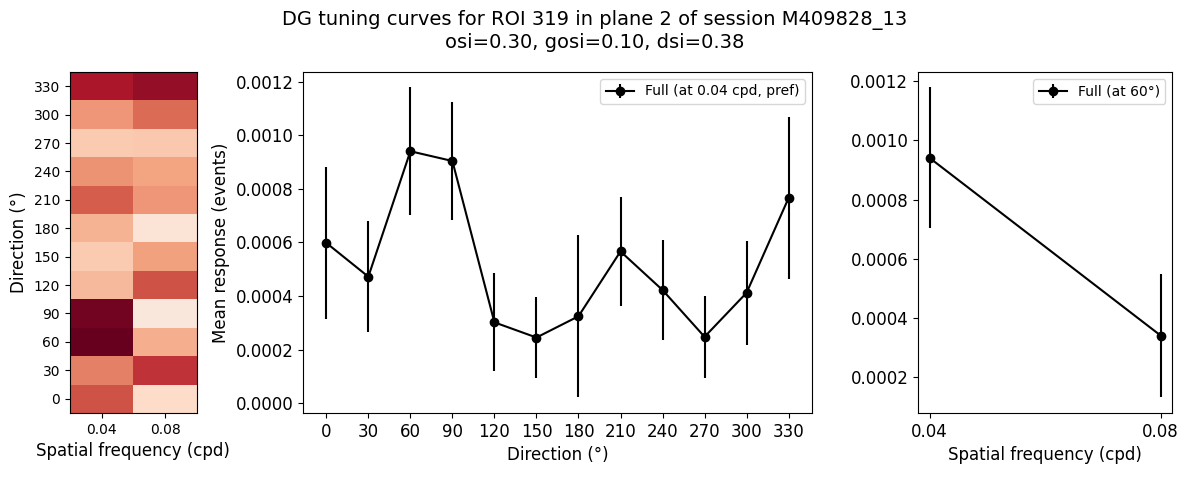

In [68]:
# Potential duplicate ROIs
# roi1, roi2 = 384, 138 # very likely duplicates
# roi1, roi2 = 469, 606
roi1, roi2 = 447, 319

print(roi1, roi2)

# Plot ROI image mask
# fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# axs[0].imshow(sess.get_roi_image_mask(1, roi1), interpolation="nearest", cmap="gray_r")
# axs[1].imshow(sess.get_roi_image_mask(2, roi2), interpolation="nearest", cmap="gray_r")

# Plot traces
# trace1, ts1 = sess.get_traces(1, roi=roi1, trace_type="events")
# trace2, ts2 = sess.get_traces(2, roi=roi2, trace_type="events")
# fig, axs = plt.subplots(figsize=(12, 4), nrows=2)
# axs[0].plot(ts1, trace1)
# axs[1].plot(ts2, trace2)
# plt.setp(axs, xlim=(500, 2000))

# Plot DGF tuning metrics
dg1.plot_roi_stim_conditions(roi1)
dg2.plot_roi_stim_conditions(roi2)
dg1.plot_roi_tuning_curves(roi1)
dg2.plot_roi_tuning_curves(roi2)

fig.tight_layout()

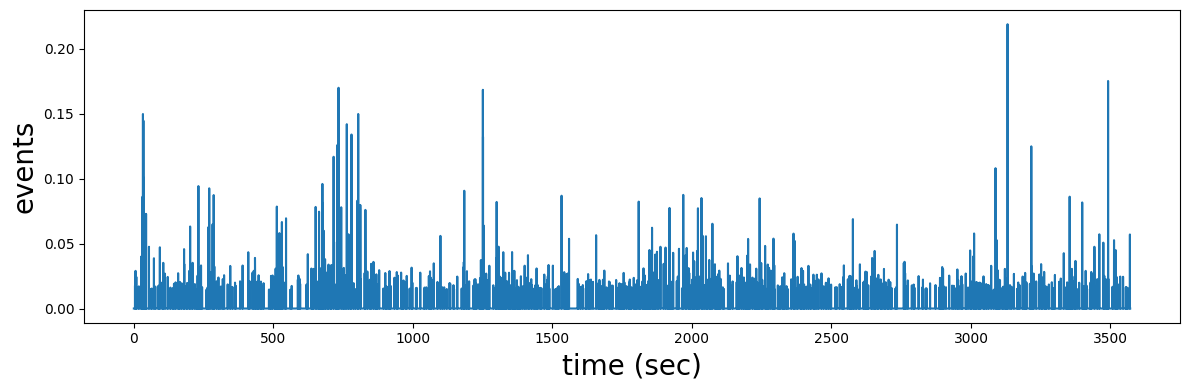

In [25]:
events, ts = sess.get_traces(plane, roi=roi, trace_type="events")

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts, events)
ax.set_xlabel('time (sec)', fontsize=20)
ax.set_ylabel('events', fontsize=20)
fig.tight_layout()